#   <center>Machine Learning Engineer Nanodegree</center>
##   <center>Project: Dogs vs. Cats Redux: Kernels Edition</center>
<center>
Author: Kyle Chen<br>
Date: 20180506<br>
Version: 20180506v1
</center>

---

###   写在前面
-   这次的毕业项目选做猫狗, 一方面是因为资料比较多, 资源比较丰富. 另外一方面, 图形识别也是当下的一大热点. 虽然毕业后可能会继续从事传统机器学习方面的研究, 但是能够有这段经历还是很不错的, 也能丰富自己的简历与深度学习的知识.
-   在这个项目中, 将通过评估几种模型与不同程度的调优, 来不断优化我们的模型框架, 以达到最终的top 10%标准.

###   准备数据
-   本文中的DataSet是已经从kaggle上拖取到本地, 并放入当前工作目录中, 但是由于Github的大小限制, 如果你想要执行并研究其中的一些代码, 请自行准备好数据集, 并存放到./DataSet目录下. kaggle传送门 <a href='https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data'>dogs-vs-cats-redux-kernels-edition/data</a>.
-   或者你可以直接运行下框的代码创建目录结构与拖取数据.

In [ ]:
# 如果你已经拖取了数据, 请勿执行此代码框中的代码
!mkdir DataSet
!mkdir saved_models
!wget -c "https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526177720&Signature=CQ9z7GqLC5d%2BCuALIgPLIleOgpbls6dKQW6ykh8NBnaoiM%2F7MRC3dDSgiQWj5xxIr%2FHK4JXtCvBY75hLX4B2q9AW2c3l2r3z2IJpvb%2BeB0MXF7dO%2Fzbm0OmXNopMcI4wjdZYDLQuX5Sy69%2Fjc2W7rYohuo0QOT0vfofeHTEN3dmrwCkcPX7AZ3c2L1ByA%2FNnZtSGGGLGxLgNsYjQlZJNziM78RS0AQ5ztJUrQhEg8EevxPESN5lVZfvJOfNsP21%2FGOJOPWcllCyqqxPqv79l0WliatTG%2FMR1BfZ14bgX2f%2BEJ7b6W3omGpM7XRcBOm4vDvWclgivzwB2Dr7Xt7r7uw%3D%3D" -O DataSet/train.zip
!wget -c "https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526177716&Signature=fHMWZ8zBkV0INrI2yVneHug3MdeZgjN2ViuucdAO7drp6iUQRZd09p3XzYL4tOy6sRL9syVk%2BSh1bf3V1qbB%2F1DAp%2BWK89GuiSHzeq0iUYi%2B8ylbUQtN2M7mQX2qsMMMr4b4bDIzOKqTkuYG8XzSQcEZWchY%2FoIHIDJjmm6nmJuu%2Bj%2F6K3jmaiL%2FnnJt1%2Firaa7l3Gys%2F4QxL9UaT6Lm%2BklbrnBqZR%2BX%2BdUMDPBXxhnBFbBQWB5ffECa50i8FKcJVtf1BO5u7Bolnx7EIwigCRsJO0gn%2BSvTLCKZYfSHuBdP2WLiSLJQXjPNjGZHx3tc8P9WEeHcQXvgdkXBRHqHVw%3D%3D" -O DataSet/test.zip
!wget -c "https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/sample_submission.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526177711&Signature=P4cytvkXEgVM4tIUHsSr%2FhxsnUwC86EWXe0gYNuI%2Bu1Eyp7prfzCVZNPvnJ2VSidXKlxhQgtRrvyGjWcSXucimeWUzbErWhm0Wz%2BNVRDoPdxzhGhv1uT0eF1D81iemBurPEXD3b5q3glI1TJfRJEc3P3u2ObzPAsQrxuz76gm9ei2dnsUiweKNv2qPpr%2FogfaxI4EKtICdKkw33CMR%2FhBXZimr0L3Vs625AOj6HrfbGMTS2x8SiL48VAGLU%2BDhfOfoB0wJirHQogzHH7u0RKmcZJhqX9jP3UW3My1pevB3eIh8GND8xPQBlsJgJ3qJ7VMeMMTiyVctcb1B52EZ88Qw%3D%3D" -O DataSet/sample_submission.csv
!unzip DataSet/train.zip -d DataSet/
!unzip DataSet/test.zip -d DataSet/

###   关于DataSet
-   先了解下数据集的组成.

In [13]:
!ls -ahl DataSet/

total 816M
drwxr-xr-x 4 root root 4.0K May 10 12:18 .
drwxr-xr-x 6 root root 4.0K May 10 12:18 ..
-rw-r--r-- 1 root root 112K Jun  8  2017 sample_submission.csv
drwxr-xr-x 2 root root 276K Sep 20  2013 test
-rw-r--r-- 1 root root 272M Jun  8  2017 test.zip
drwxr-xr-x 2 root root 740K Sep 20  2013 train
-rw-r--r-- 1 root root 544M Jun  8  2017 train.zip


-   test目录下存放的是kaggle准备好的测试集.
-   train目录下存放的是训练集, 当然, 还需要将其细分为训练集与验证集两个部分.

In [14]:
!ls -ahl DataSet/train/ | head -n 5

total 595M
drwxr-xr-x 2 root root 740K Sep 20  2013 .
drwxr-xr-x 4 root root 4.0K May 10 12:18 ..
-rw-r--r-- 1 root root  13K Sep 20  2013 cat.0.jpg
-rw-r--r-- 1 root root  22K Sep 20  2013 cat.10000.jpg
ls: write error: Broken pipe


-   发现数据集命名是有规则的, 遵循label.n.jpg的原则.

In [16]:
!echo "cats | $(find DataSet/train/ -name 'cat*' | wc -l)"
!echo "dogs | $(find DataSet/train/ -name 'dog*' | wc -l)"

cats | 12500
dogs | 12500


-   发现cats/dogs样本类型分布均匀.
-   大致过了一遍数据集里面的数据之后, 有几个异常值需要删除的.

In [17]:
!rm -rf DataSet/train/cat.7377.jpg DataSet/train/cat.4085.jpg

###   Import Libs

In [18]:
# 导入我们后面需要用到的库
import os
import re
import cv2
import h5py
import numpy as np
import pandas as pd           
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.applications import xception
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers import Input, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline   

###   Initial Global Variables

In [19]:
# initial global variables
TRAIN_DIR = 'DataSet/train'
TEST_DIR = 'DataSet/test'
TRANSFER_DIR = 'DataSet/transfer'
TRANSFER_TRAIN_DIR = 'DataSet/transfer/train'
TRANSFER_TEST_DIR = 'DataSet/transfer/test'
RESULT_SAMP = 'DataSet/sample_submission.csv'
RESULT_FILE = 'DataSet/result.csv'
np.random.seed(2018)

###   导入数据集

-   读取数据与分类信息

In [20]:
# load data from TRAIN_DIR
def load_data(width, height, channels):
    img_list = os.listdir(TRAIN_DIR)
    nums = len(img_list)
    data = np.empty((nums, width, height, channels), dtype="float32")
    label = np.empty((nums, ))
    
    i = 0
    while i < nums:
        img = img_list[i]
        imgObj = Image.open("{}/{}".format(TRAIN_DIR, img))
        arr = np.asarray(imgObj, dtype="float32")
        arr.resize((width, height, channels))
        data[i, :, :, :] = arr
        
        if re.match(r'^cat\.', img) != None:
            label[i] = 0
            
        elif re.match(r'^dog\.', img) != None:
            label[i] = 1            
        i += 1
    return(data, label)

###   CNN模型框架
-   Load数据

In [21]:
# run load data
data, label = load_data(224, 224, 3)
data, label = shuffle(data, label)

-   数据可视化

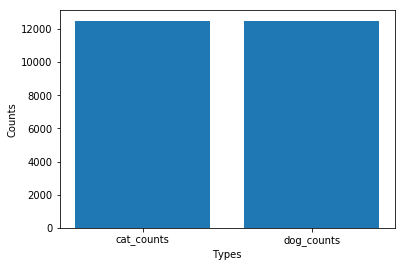

In [22]:
cat_counts = sum([ 1 for x in label if x == 0 ])
dog_counts = sum([ 1 for x in label if x == 0 ])
plt.bar(['cat_counts', 'dog_counts'], [cat_counts, dog_counts])
plt.xlabel('Types')
plt.ylabel('Counts')
plt.show()

-   CNN模型设计

In [23]:
cnn_model = Sequential()
shape_input = (len(data[0]), len(data[0][0]), len(data[0][0][0]))
cnn_model.add(Conv2D(filters=16, kernel_size=2, input_shape=shape_input))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2, padding='valid'))
cnn_model.add(Dense(133, activation='relu'))
cnn_model.add(Conv2D(filters=32, kernel_size=2))
cnn_model.add(MaxPooling2D(pool_size=2, padding='valid'))
cnn_model.add(Dense(133, activation='relu'))
cnn_model.add(Conv2D(filters=64, kernel_size=2))
cnn_model.add(MaxPooling2D(pool_size=2, padding='valid'))
cnn_model.add(GlobalAveragePooling2D(dim_ordering='default'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
batch_normalization_2 (Batch (None, 223, 223, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dense_4 (Dense)              (None, 111, 111, 133)     2261      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      17056     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dense_5 (Dense)              (None, 55, 55, 133)       4389      
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `GlobalAveragePooling2D` call to the Keras 2 API: `GlobalAveragePooling2D(data_format=None)`
  if sys.path[0] == '':


-   编译模型

In [24]:
# 编译模型
# 在keras中, 提供binary_crossentropy函数, 就是我们需要的LogLoss
cnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

-   训练CNN模型

In [25]:
# 这里在8c 16g的mbpr上跑了差不多两个半小时
# 12c 60g P100跑了两分钟
epochs = 10
batch_size = 128
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.cnn.hdf5', 
                                   verbose=1, save_best_only=True)
hist_cnn = cnn_model.fit(data, label, validation_split = 0.3,
                epochs = epochs, batch_size = batch_size,
                callbacks=[checkpointer], verbose=1)

Train on 17498 samples, validate on 7500 samples
Epoch 1/10
17498/17498 [==============================] - 47s 3ms/step - loss: 0.6797 - acc: 0.5686 - val_loss: 0.7046 - val_acc: 0.5308

Epoch 00001: val_loss improved from inf to 0.70461, saving model to saved_models/weights.best.cnn.hdf5
Epoch 2/10
17498/17498 [==============================] - 46s 3ms/step - loss: 0.6610 - acc: 0.6006 - val_loss: 0.6678 - val_acc: 0.5719

Epoch 00002: val_loss improved from 0.70461 to 0.66777, saving model to saved_models/weights.best.cnn.hdf5
Epoch 3/10
17498/17498 [==============================] - 46s 3ms/step - loss: 0.6511 - acc: 0.6176 - val_loss: 0.7008 - val_acc: 0.5469

Epoch 00003: val_loss did not improve from 0.66777
Epoch 4/10
17498/17498 [==============================] - 46s 3ms/step - loss: 0.6443 - acc: 0.6200 - val_loss: 0.6337 - val_acc: 0.6473

Epoch 00004: val_loss improved from 0.66777 to 0.63373, saving model to saved_models/weights.best.cnn.hdf5
Epoch 5/10
17498/17498 [=======

-   学习曲线

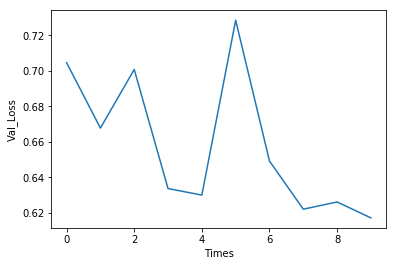

In [51]:
# val_loss学习曲线
plt.plot(hist_cnn.history['val_loss'])
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.show()

-   这里可以发现, 用CNN优化之后, 还是在0.63894. LogLoss没有太大的提升.

###   使用Xception
-   将train下的数据分类至transfer目录下

In [27]:
# 将train下的数据分类并拷贝至transfer/train/{cat,dog}, test拷贝至DataSet/transfer/test/pic/目录下
!mkdir DataSet/transfer/train/cat -p
!mkdir DataSet/transfer/train/dog
!mkdir DataSet/transfer/test/pic -p
!find DataSet/train -name 'cat.*' -exec cp -rf {} DataSet/transfer/train/cat/ \;
!find DataSet/train -name 'dog.*' -exec cp -rf {} DataSet/transfer/train/dog/ \;
!find DataSet/test -name '*.jpg' -exec cp -rf {} DataSet/transfer/test/pic/ \;

-   加载数据

In [28]:
# run load data, change size to Xception default (299,299)
img_size = (299, 299)
gen = ImageDataGenerator()
X_train_gen = gen.flow_from_directory(TRANSFER_TRAIN_DIR, img_size, shuffle = False, 
                                        batch_size = 16)
X_test_gen = gen.flow_from_directory(TRANSFER_TEST_DIR, img_size, shuffle = False, 
                                        batch_size = 16, classes = None)

Found 24998 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


-   训练模型设计

In [29]:
input_tensor = Input((img_size[0], img_size[1], 3))
input_tensor = Lambda(xception.preprocess_input)(input_tensor)
Xception_base = Xception(input_tensor = input_tensor, 
                             weights = 'imagenet', include_top = False)
Xception_model = Model(Xception_base.input, GlobalAveragePooling2D()(Xception_base.output))
Xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

-   利用Xception训练特征向量

In [30]:
X_train = Xception_model.predict_generator(X_train_gen, verbose=1)
X_test = Xception_model.predict_generator(X_test_gen, verbose=1)

782/782 [==============================] - 92s 117ms/step


-   保存特征权重

In [31]:
with h5py.File('saved_models/weights.Xception.hdf5') as fp:
        fp.create_dataset('train', data = X_train)
        fp.create_dataset('test', data = X_test)
        fp.create_dataset('label', data = X_train_gen.classes)

-   导入我们刚刚训练好的特征向量

In [43]:
X_train = []
X_test = []
with h5py.File('saved_models/weights.Xception.hdf5', 'r') as fp:
    X_train.append(np.array(fp['train']))
    X_test.append(np.array(fp['test']))
    y_train = np.array(fp['label'])
    
X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)
X_train, y_train = shuffle(X_train, y_train)

-   使用Xception训练好的特征向量构建模型

In [44]:
input_tensor = Input(X_train.shape[1:])
Xception_model = Model(input_tensor, Dropout(0.5)(input_tensor))
Xception_model = Model(Xception_model.input, Dense(1, activation = 'sigmoid')(Xception_model.output))
Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


-   编译模型

In [45]:
Xception_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

-   使用Xception训练模型

In [46]:
epochs = 10
batch_size = 128
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                                   verbose=1, save_best_only=True)
hist_Xception = Xception_model.fit(X_train, y_train, validation_split = 0.3,
                    epochs = epochs, batch_size = batch_size, verbose=1,
                    callbacks=[checkpointer])

Train on 17498 samples, validate on 7500 samples
Epoch 1/10
17498/17498 [==============================] - 1s 61us/step - loss: 0.1492 - acc: 0.9771 - val_loss: 0.0503 - val_acc: 0.9927

Epoch 00001: val_loss improved from inf to 0.05033, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/10
17498/17498 [==============================] - 0s 29us/step - loss: 0.0420 - acc: 0.9912 - val_loss: 0.0284 - val_acc: 0.9933

Epoch 00002: val_loss improved from 0.05033 to 0.02835, saving model to saved_models/weights.best.Xception.hdf5
Epoch 3/10
17498/17498 [==============================] - 1s 29us/step - loss: 0.0294 - acc: 0.9924 - val_loss: 0.0229 - val_acc: 0.9940

Epoch 00003: val_loss improved from 0.02835 to 0.02288, saving model to saved_models/weights.best.Xception.hdf5
Epoch 4/10
17498/17498 [==============================] - 0s 28us/step - loss: 0.0255 - acc: 0.9929 - val_loss: 0.0208 - val_acc: 0.9947

Epoch 00004: val_loss improved from 0.02288 to 0.02079, saving mode

-   学习曲线

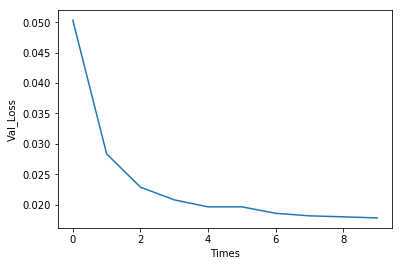

In [52]:
# val_loss学习曲线
plt.plot(hist_Xception.history['val_loss'])
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.show()

-   可以发现, 使用Xception比直接使用CNN的表现要好很多.
###   尝试往kaggle上提交


-   对测试集进行预测

In [41]:
y_test = Xception_model.predict(X_test)
y_test = y_test.clip(min = 0.005, max = 0.995)

-   保存数据

In [42]:
num = [ int(re.sub('.jpg', '', re.sub('.*\/', '', f))) for f in X_test_gen.filenames ]
df = pd.read_csv(RESULT_SAMP)
for i in range(len(num)):
    df.set_value(num[i] - 1, 'label', y_test[i])
df.to_csv(RESULT_FILE, index=None)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
